In [2]:
%matplotlib -l

Available matplotlib backends: ['osx', 'qt4', 'qt5', 'gtk3', 'notebook', 'wx', 'qt', 'nbagg', 'gtk', 'tk', 'inline']


In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
#from mpl_toolkits.basemap import Basemap
#import cartopy.crs as ccrs
import pyshtools as pysht
import pyshtools.shtools as sht
import pyshtools.constant as shconstant
import numpy as np
#from scipy.special import erfi
import MapDrawer as MD
#import shelve
plt.rcParams['figure.figsize'] = [12.0,8.0]
#from sympy.physics.quantum import cg as CG

In [2]:
# These are in the "geodesy" normalization convention: the SHTools default (norm=1)
max_degree = 2190
#max_degree = 2159
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',max_degree)

In [3]:
# These are appropriate values for the GRS80 model
omega_earth = 7.292115e-5
a_earth = 6378137.
b_earth = 6356752.3141
GM_earth = 3.986005e14
f_earth = 0.003352810681183637418
pot_ref_geoid_earth = 6263686.0850E1

print a_earth - shconstant.r0_pot_earth


0.700000000186


In [3]:
# These are the values for WGS84 stored within SHTools itself.
omega_earth = shconstant.wgs84_omega
#print omega_earth
a_earth = shconstant.wgs84_a
#print a_earth
b_earth = shconstant.wgs84_b
#print b_earth
GM_earth = shconstant.wgs84_gm
# That differs in the 7th decimal place from the value given above for GRS80
#print GM_earth
f_earth = shconstant.wgs84_f
# That varies in the 9th significant digit from the value given above for GRS80.
#print f_earth
pot_ref_geoid_earth = shconstant.wgs84_u0
#print pot_ref_geoid_earth
# That varies in the 7th significant digit from the value given above for GRS80
r0pot_earth = shconstant.r0_pot_earth

In [4]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = r0pot_earth,
                            #r0pot = a_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=1)

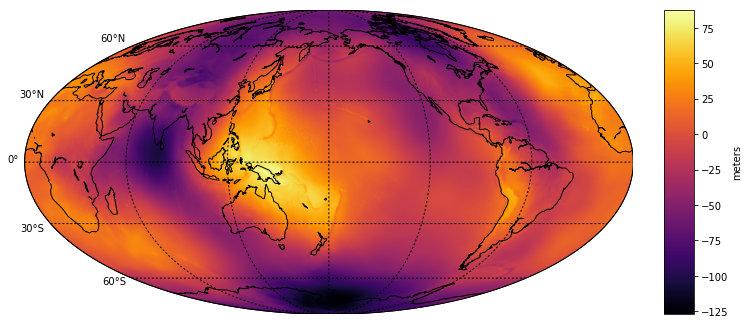

In [5]:
md = MD.MapDrawer('moll',geoid)
md.DrawMap(geoid,lon_0=180,units_label='meters')

4382 8764


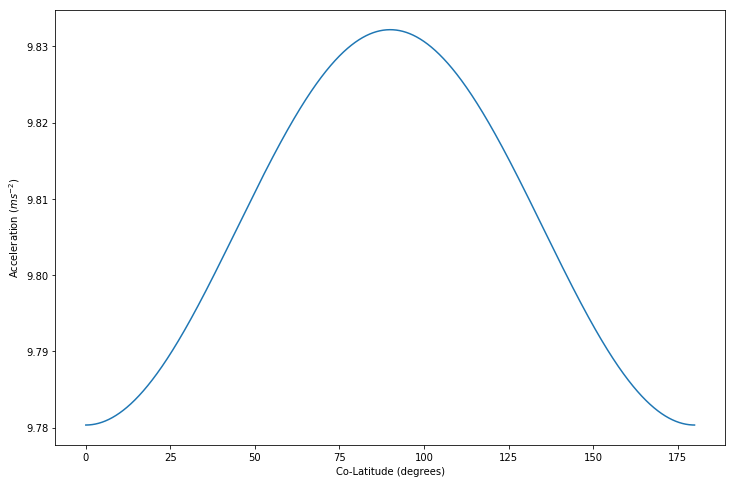

In [6]:
nlat,nlon = geoid.shape
print nlat, nlon
dlat = 180. / nlat
lats = np.linspace(0. + (dlat / 2.), 180. - (dlat / 2.), nlat)
#plt.plot(lats)
normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
plt.plot(lats,ng)
plt.ylabel('Acceleration ($m s^{-2})$')
plt.xlabel('Co-Latitude (degrees)')
#print normal_gravs

-1244.05382346 862.788377121


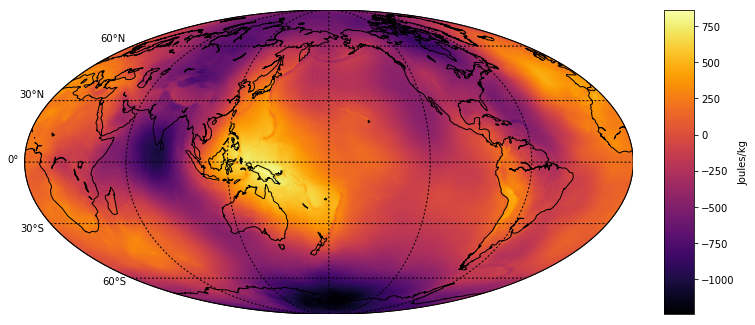

In [7]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
fig = plt.figure()
md.DrawMap(T,lon_0=180,units_label='Joules/kg')
#fig.savefig('Timage.png')
print T.min(),T.max()

In [8]:
# We need to create a 4\pi normalized (norm=1) SH expansion of T. No CS phase 
# DON'T FORGET TO CALL WITH SAMPLING=2  !!!!!!!!
T_4Pi_SH = sht.SHExpandDH(T, lmax_calc=720,norm=1,sampling=2)

In [11]:
# THIS ONE IS FROM BRUN'S FORMULA
rad, theta, phi, total, pot = sht.MakeGravGridDH (T_4Pi_SH, 
                                                  gm=GM_earth, 
                                                  r0=r0pot_earth, 
                                                  a=a_earth, 
                                                  f=f_earth,
                                                  sampling=2,
                                                  normal_gravity=0,
                                                  lmax_calc=720)


In [8]:
# THIS ONE IS FROM SHTOOLS DIRECTLY
rad, theta, phi, total, pot = sht.MakeGravGridDH (coeffs, 
                                                  gm=GM_earth, 
                                                  r0=r0pot_earth, 
                                                  a=a_earth, 
                                                  f=f_earth,
                                                  sampling=2,
                                                  normal_gravity=1,
                                                  omega=omega_earth,
                                                  lmax_calc=720)



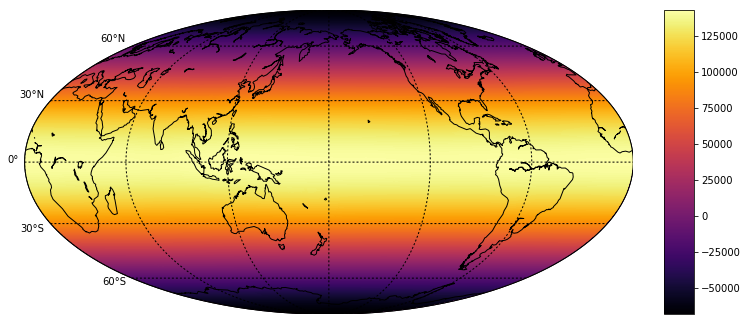

In [9]:
md_small = MD.MapDrawer('moll',pot)
md_small.DrawMap(pot)
# The order of magnitude from this result is WAAAAAY off. 
# I need to track this down with the author of the code before I go much further...


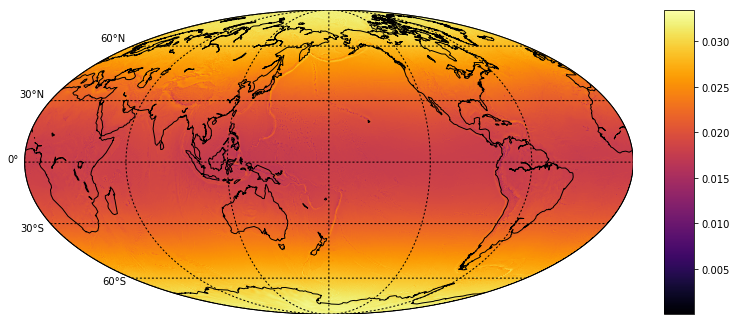

In [15]:
md_small.DrawMap(rad)

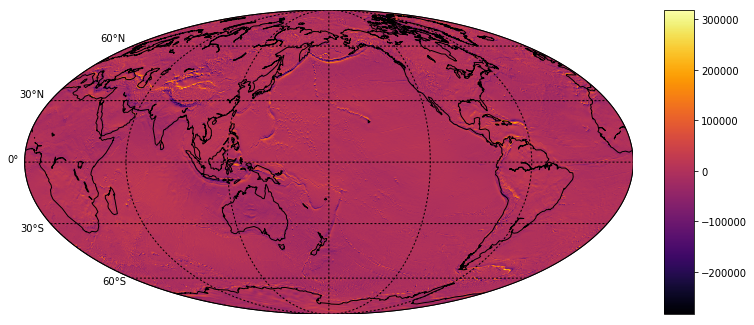

In [14]:
md_small.DrawMap(theta)

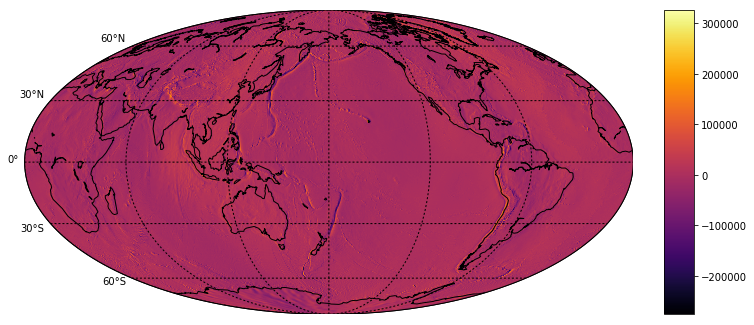

In [15]:
md_small.DrawMap(phi)

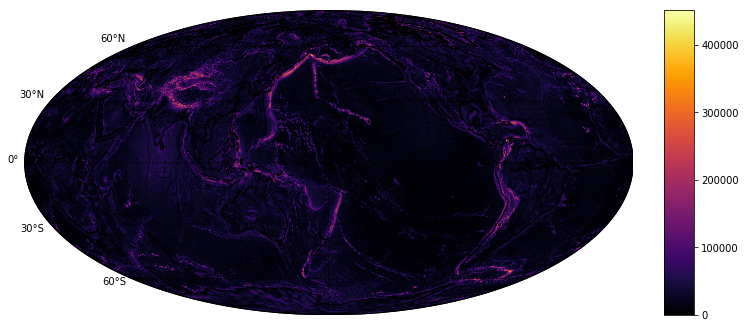

In [16]:
md_small.DrawMap(total)

In [11]:
pot.shape

(1442, 2884)

In [17]:
Ntheta,Nphi = pot.shape
(theta_line,dTheta) = np.linspace(0.,np.pi,num=Ntheta, endpoint=False, retstep=True, dtype=np.float64)
print Ntheta, dTheta, dTheta*6371., len(theta_line)

(phi_line,dPhi) = np.linspace(0.,2.*np.pi,num=Nphi, endpoint=False, retstep=True, dtype=np.float64)
print Nphi, dPhi, dPhi*6371., len(phi_line)


1442 0.0021786356821 13.8800879307 1442
2884 0.0021786356821 13.8800879307 2884


In [50]:
theta_array = np.ones_like(pot,dtype=np.float64)*theta_line[:,np.newaxis]
phi_array = np.ones_like(pot,dtype=np.float64)*phi_line[np.newaxis,:]

#md_small.DrawMap(phi_array)

For spherical polar coordinates, the position vector $\hat{r}$ can be expressed in geocentric Cartesian coordinates (e.g. Arfken and Weber, eqn. 2.36) by:
$$ \begin{align}
x = &r \sin (\theta) \cos (\phi) \\
y = &r \sin (\theta) \sin (\phi) \\
z = &r \cos (\theta)
\end{align}$$
Let's build arrays containing those position vector components.

In [56]:
pos_x_hat = np.sin(theta_array) * np.cos(phi_array)
pos_y_hat = np.sin(theta_array) * np.sin(phi_array)
pos_z_hat = np.cos(theta_array)

#md_small.DrawMap(pos_x_hat)

OK. Now we need to express local $\hat{r},\hat{\theta},\hat{\phi}$ basis vectors at all positions. From Arfken and Weber (eqn. 2.42) we see:

$$ \begin{align}
\hat{r} = &\hat{x} \sin(\theta) \cos(\phi) + \hat{y} \sin{\theta} \sin(\phi) + \hat{z} \cos(\theta) \\
\hat{\theta} = &\hat{x} \cos(\theta) \cos(\phi) + \hat{y} \cos{\theta} \sin(\phi) - \hat{z} \sin(\theta) \\
\hat{\phi} = &-\hat{x}\sin(\phi) + \hat{y}\cos(\phi) 
\end{align}$$

Let's build arrays containing those local basis vector components.

In [74]:
r_hat = np.array((np.sin(theta_array)*np.cos(phi_array),
                  np.sin(theta_array)*np.sin(phi_array),
                  np.cos(theta_array)),
                 dtype=np.float64)
#md_small.DrawMap(r_hat[1])

theta_hat = np.array((np.cos(theta_array)*np.cos(phi_array),
                      np.cos(theta_array)*np.sin(phi_array),
                     -np.sin(theta_array)),
                     dtype=np.float64)
#md_small.DrawMap(theta_hat[0])

phi_hat = np.array((-np.sin(phi_array),
                     np.cos(phi_array),
                     np.zeros_like(pot)),
                     dtype=np.float64)
#md_small.DrawMap(phi_hat[0])


We are finally ready to look at Cartesian components of the gravity field!

Let's calculate the $z$ component of the gravity. It should be the arrays (rad\*$\hat{r}$ + theta\*$\hat{\theta}$ + phi\*$\hat{\phi}$)[2]... 

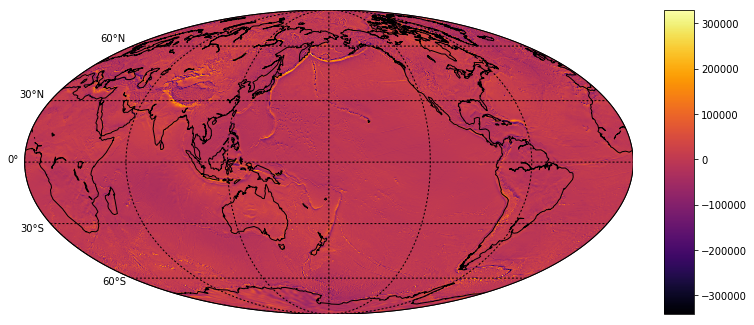

In [79]:
cartesian_field = (rad[np.newaxis,:,:]*r_hat + 
                   theta[np.newaxis,:,:]*theta_hat +
                   phi[np.newaxis,:,:]*phi_hat)
md_small.DrawMap(cartesian_field[2])

In [8]:
# In order to exactly match the Driscoll-Healy convolution theorem details, 
# we'll use the ortho-normalized (norm=4) version, with CS phase...
# DON'T FORGET TO CALL WITH SAMPLING=2  !!!!!!!!
T_SH = sht.SHExpandDH(T, lmax_calc=max_degree,norm=4,sampling=2,csphase=-1)

-1046.80278108 863.029327092


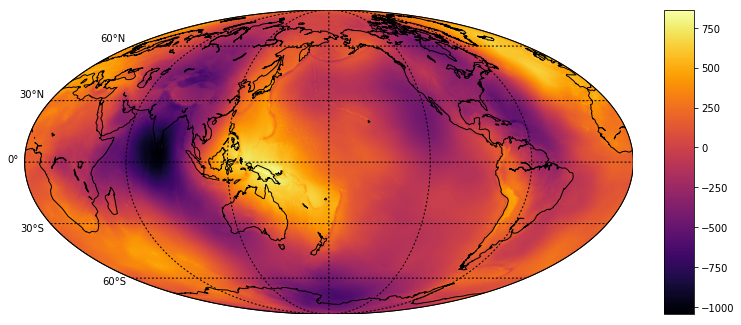

In [9]:
# Sanity check: Do we reproduce T as a grid from the T_SH coefficients?
T_test = sht.MakeGridDH(T_SH,sampling=2,csphase=-1,norm=4)
md.DrawMap(T_test)
print T_test.min(),T_test.max()

In [10]:
T_err = T-T_test
#plt.imshow(np.arcsinh(T_err))
print T_err.min(),T_err.max()

-0.00493284175093 0.00373992019576


OK. We're going to attempt to calculate the *field* in the z (towards the North pole) direction from vector spherical harmonics.

Essential VSH math is from https://web2.ph.utexas.edu/~gleeson/ElectricityMagnetismAppendixE.pdf . Equation numbers starting with E below reference this development.

The first relationship maps our standard (Condon-Shortly phase) SH into something useful in VSH (E.77):

$$\vec{Y}_{l,m:1,\mu}(\hat{r}) \equiv Y^m_l (\hat{r}) \hat{\chi}_\mu \qquad(1)$$

The $\hat{\chi}_\mu$ are unit vectors on the sphere. In particular (E.58), $\hat{\chi}_0 = \hat{z}$ .

Defining a reduced form (E.79) and substituting from the previous expression we find:

$$\vec{Y}^M_{Jl}(\hat{r}) \equiv \sum_{\mu} c(l,1,J;M-\mu,\mu,M) \vec{Y}_{l,M-\mu:1,\mu}(\hat{r}) = \sum_{\mu} c(l,1,J;M-\mu,\mu,M) Y^{M-\mu}_l (\hat{r}) \hat{\chi}_\mu \qquad(2)$$
where the $c(l,1,J;m,\mu,M)$ are the "well known" Clebsch-Gordan coefficients.

The _point_ of all of this, is that the gradient of a scalar field expressed in spherical harmonics can be written (E.85) as:
$$\begin{align}\vec{\nabla} f(r) Y^m_l (\hat{r}) = 
&-\left[\frac{l+1}{2l+1}\right]^{\frac{1}{2}} 
\left( \frac{d}{dr} - \frac{l}{r} \right) f(r)\vec{Y}^m_{ll+1}(\hat{r})\\
&+\left[\frac{l}{2l+1}\right]^{\frac{1}{2}} 
\left( \frac{d}{dr} + \frac{l+1}{r} \right) f(r)\vec{Y}^m_{ll-1}(\hat{r}) \qquad(3)
\end{align}
$$

Substituting (2) into (3), we write:
$$
\begin{align}\vec{\nabla} f(r) Y^m_l (\hat{r}) = 
&-\left[\frac{l+1}{2l+1}\right]^{\frac{1}{2}} 
\left( \frac{d}{dr} - \frac{l}{r} \right) f(r)\ \sum_{\mu} c(l+1,1,l;m-\mu,\mu,m) Y^{m-\mu}_{l+1} (\hat{r}) \hat{\chi}_\mu\\
&+\left[\frac{l}{2l+1}\right]^{\frac{1}{2}} 
\left( \frac{d}{dr} + \frac{l+1}{r} \right) f(r)\sum_{\mu} c(l-1,1,l;m-\mu,\mu,m) Y^{m-\mu}_{l-1} (\hat{r}) \hat{\chi}_\mu \qquad(4)
\end{align}
$$

It's not clear to me whether it's legitimate or not to simplify to $\mu=0$ before or after evaluating the $d/dr$ stuff, so in a surplus of caution, I'm going to carry that sum along for the moment.

Now, the $d/dr$ term acts only on the radial portion of the function. Adapting Arfken and Weber's (4th ed., 1995, eqn. 12.149) expansion of a gravity field to our notation, we see that:
$$U(r,\theta,\phi) = \frac{GM}{R}\left[ \frac{R}{r} - \sum_{n=2}^{\infty} \sum_{m=-n}^n \left( \frac{R}{r}\right)^{n+1} \right] \left\{ function\ of Y^m_n(\hat{r})\right\} \qquad(5)
$$
This means that $f(r)$ in (4) from (5) is 
$$f(r) = \left[ \frac{R}{r} - \left( \frac{R}{r}\right)^{l+1} \right]$$
That first term is not contained in our disturbing potential $T$ so we will drop it.

Hence, the actual expression we care about to insert into (4) is:
$$f(r) = - \left( \frac{R}{r}\right)^{(l+1)}\qquad(6)$$
and hence
$$\frac{df}{dr} = \frac{(l+1)}{r}\left( \frac{R}{r}\right)^{(l+1)}$$


In [1]:
co_lats = np.linspace(0.,np.pi,num=T.shape[0],endpoint=True,dtype=np.double)
cos_co_lats = np.abs(np.cos(co_lats))
plt.plot(co_lats)
plt.plot(cos_co_lats)

NameError: name 'np' is not defined

In [17]:
T_xray = T * cos_co_lats[:,np.newaxis]

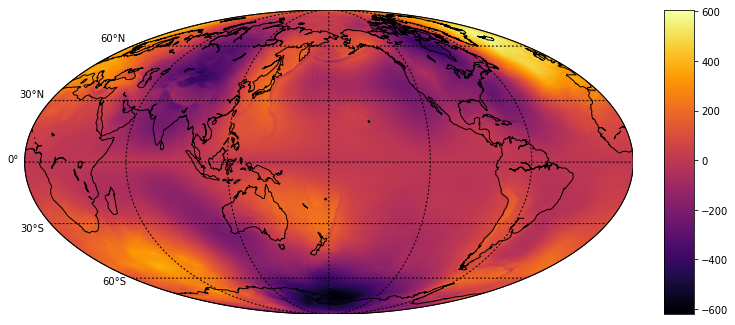

In [18]:
md.DrawMap(T_xray)

In [22]:
r_inner = 6371000. - 400000.
# r_inner = 0.5290 *6371000.
#rpm_2D = -make_Rpm(R_e = 6371000., r_i = r_inner, co_lats = co_lats, shp = T.shape)
print 6371000. - r_inner

400000.0
